In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
retail = pd.read_excel('OnlineRetail.xlsx')

In [3]:
retail.duplicated().sum()

5268

In [4]:
retail = retail.drop_duplicates()

In [5]:
any(retail['CustomerID'].isnull())

True

In [6]:
retail.dropna(subset=['CustomerID'], inplace=True)

In [7]:
retail['CustomerID'] = retail['CustomerID'].astype(str).str.rstrip(',0').str.rstrip('.')
retail['StockCode'] = retail['StockCode'].astype(str).str.rstrip(',0')

In [8]:
retail.rename(columns={'CustomerID':'user_code', 'StockCode':'product_id','Description':'product_name'}, inplace=True)

In [9]:
retail.describe()

,Quantity,UnitPrice
count,401604.000000,401604.000000
mean,12.183273,3.474064
std,250.283037,69.764035
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [10]:
indexretail = retail[(retail['Country'] != 'United Kingdom') | (retail['InvoiceDate'].dt.year != 2011)].index
retail.drop(indexretail, inplace=True)

In [11]:
user_product_dic = retail.groupby('user_code')['product_id'].apply(set).to_dict()

In [12]:
product_user_dic = retail.groupby('product_id')['user_code'].apply(set).to_dict()

In [13]:
product_id_name_dic = dict(zip(retail['product_id'],retail['product_name']))

#数据结构全部填满

In [14]:
product_per_user_li = [len(x) for x in user_product_dic.values()]

In [15]:
print('# of users:', len(user_product_dic))
print('# of products:', len(product_user_dic))

# of users: 3835
# of products: 3588


In [16]:
from scipy import stats

In [17]:
print(stats.describe(product_per_user_li))

DescribeResult(nobs=3835, minmax=(1, 1603), mean=58.69074315514993, variance=6207.108821435057, skewness=5.8338167234043965, kurtosis=72.60364097540139)


In [18]:
product_per_user_li[:10]

[1, 39, 1603, 160, 55, 6, 41, 1, 25, 57]

In [19]:
from collections import Counter

In [20]:
plot_data_all = Counter(product_per_user_li)

In [21]:
plot_data_x = list(plot_data_all.keys())
plot_data_y = list(plot_data_all.values())

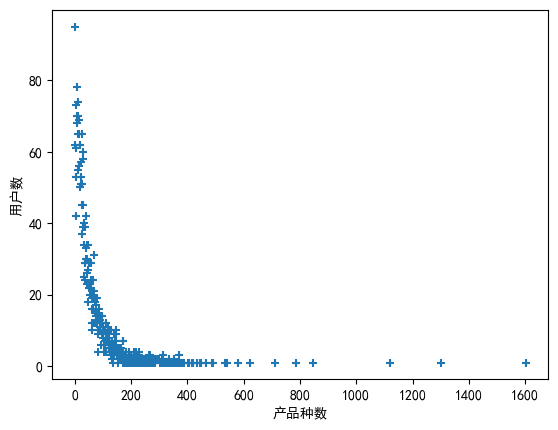

In [22]:
plt.rcParams['font.family'] ='SimHei'
plt.scatter(plot_data_x, plot_data_y, marker='+')
plt.xlabel('产品种数')
plt.ylabel('用户数')
plt.show()

In [23]:
#排除异常购买模式的用户
min_product_user_li = [k for k,v in user_product_dic.items() if len(v)==1]
max_product_user_li = [k for k,v in user_product_dic.items() if len(v)>=600]

print('# of users purchased one product: %d' %(len(min_product_user_li)))
print('# of users purchased more than 600 products: %d' %(len(max_product_user_li)))

# of users purchased one product: 95
# of users purchased more than 600 products: 7


In [24]:
user_product_dic = {k:v for k,v in user_product_dic.items() if len(v) >1 and len(v) < 600}
print('# of left users: %d' %(len(user_product_dic)))

# of left users: 3733


In [25]:
id_product_dic = {}
for product_set_li in user_product_dic.values():
    for x in product_set_li:
        if x in id_product_dic:
            product_id = id_product_dic[x]
        else:
            id_product_dic.setdefault(x, len(id_product_dic))
print('# of left items:%d' %(len(id_product_dic)))

# of left items:3568


In [26]:
#用户ID引用字典
id_user_dic = {}
#用作聚类输入的列表
user_product_vec_li = []
#聚类中使用的产品总种数，即转换为独热编码的特征种数
all_product_count=len(id_product_dic)

for user_code, product_per_user_set in user_product_dic.items():
    #生成长度为产品种类的列表
    user_product_vec = [0] * all_product_count
    #利用id_user_dic的长度，将用户ID转换为从0开始的user_id
    id_user_dic[len(id_user_dic)] = user_code
    for product_name in product_per_user_set:
        user_product_vec[id_product_dic[product_name]] = 1
    user_product_vec_li.append(user_product_vec)

In [27]:
print(id_user_dic[0])

12747


In [28]:
print(user_product_dic['12747'])

{'48194', '22795', '22606', '85099B', '22607', '82494L', '85123A', '85099C', '22427', '85099F', '2212', '48138', '22429', '71459', '232', '22411', '22469', '82486', '22386', '2243', '23201', '23521', '48173C', '82482', '22425', '21745', '23199', '23581', '21929', '22424', '20711', '82484', '85062', '23522', '21754', '22605', '22763', '84879', '21136'}


In [29]:
#print(user_product_vec_li[0])

In [30]:
print(len(user_product_vec_li[0]))

3568


In [31]:
from sklearn import cluster

In [32]:
np.random.shuffle(user_product_vec_li)

In [33]:
train_data=user_product_vec_li[:2500]
test_data=user_product_vec_li[2500:]
print('# of train data:%d, # of test data %d' %(len(train_data),len(test_data)))

# of train data:2500, # of test data 1233


In [34]:
km_predict = cluster.KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=20).fit(train_data)
km_predict_result = km_predict.predict(test_data)
print(km_predict_result)

[1 1 1 ... 1 1 1]


In [35]:
#正确确定族数K
#定量分析

In [41]:
#sihouette coefficient
from sklearn.metrics import silhouette_score
test_data = np.array(user_product_vec_li)
for k in range(2,9):
    km = cluster.KMeans(n_clusters=k).fit(test_data)
    print('score for %d clusters: %.3f' %(k, silhouette_score(test_data, km.labels_)))


score for 2 clusters: 0.345
score for 3 clusters: 0.345
score for 4 clusters: 0.227
score for 5 clusters: 0.183
score for 6 clusters: 0.192
score for 7 clusters: 0.202
score for 8 clusters: 0.207


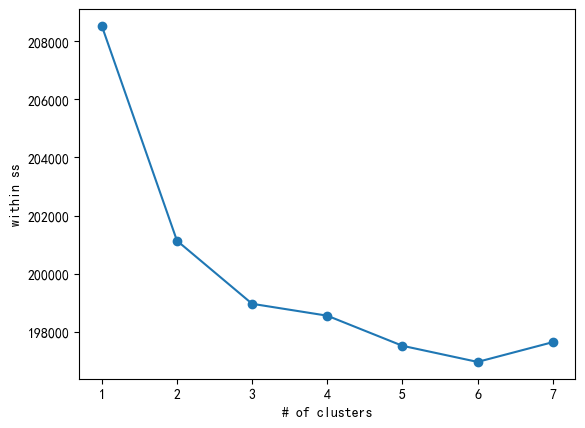

In [43]:
#肘部法则
ssw_dict = {}
for k in range(1,8):
    km = cluster.KMeans(n_clusters=k).fit(test_data)
    ssw_dict[k] = km.inertia_

plt.plot(ssw_dict.keys(),ssw_dict.values(),linestyle='-', marker='o')
plt.xlabel('# of clusters')
plt.ylabel('within ss')
plt.show()

In [45]:
#正确确定族数K
#定性分析

In [61]:
#求族内用户所购产品关键词
def analyze_clusters_keywords(labels, product_id_name_dic, user_product_dic, id_user_dic):
    #输出各族ID与族内用户数
    print(Counter(labels))
    cluster_item ={}
    for i in range(len(labels)):
        cluster_item.setdefault(labels[i],[])

        for x in user_product_dic[id_user_dic[i]]:
            cluster_item[labels[i]].extend([product_id_name_dic[x]])
    
    '''
    for cluster_id, product_name in cluster_item.items():
        product_name_keyword = (' ').join(product_name).split()
        
        print('cluster_id:', cluster_id)
        print(Counter(product_name_keyword).most_common(20))'''
    for cluster_id, product_name in cluster_item.items():
        biggram=[]
        product_name_keyword = (' ').join(product_name).replace('OF','').split()
        for i in range(len(product_name_keyword)-1):
            biggram.append(' '.join(product_name_keyword[i:i+2]))
        
        print('cluster_id',cluster_id)
        print(Counter(biggram).most_common(20))

In [62]:
km = cluster.KMeans(n_clusters=2, n_init=10, max_iter=20)
km.fit(test_data)
analyze_clusters_keywords(km.labels_,product_id_name_dic, user_product_dic, id_user_dic)

Counter({1: 3202, 0: 531})
cluster_id 1
[('RED RETROSPOT', 5558), ('JUMBO BAG', 4644), ('METAL SIGN', 4166), ('LUNCH BAG', 3997), ('T-LIGHT HOLDER', 3961), ('HOT WATER', 3221), ('WATER BOTTLE', 3221), ('SET 3', 3169), ('CAKE CASES', 3046), ('VINTAGE CHRISTMAS', 2908), ('SET 6', 2444), ('DOLLY GIRL', 2163), ('BAG VINTAGE', 2083), ("50'S CHRISTMAS", 1961), ('SET 4', 1939), ('PACK 12', 1924), ('VINTAGE DOILY', 1915), ('HANGING HEART', 1882), ('HOME SWEET', 1757), ('SWEET HOME', 1757)]
cluster_id 0
[('RED RETROSPOT', 933), ('JUMBO BAG', 770), ('T-LIGHT HOLDER', 685), ('METAL SIGN', 668), ('LUNCH BAG', 665), ('CAKE CASES', 557), ('VINTAGE CHRISTMAS', 511), ('HOT WATER', 508), ('WATER BOTTLE', 508), ('SET 3', 495), ('DOLLY GIRL', 430), ('SET 6', 414), ('BAG VINTAGE', 368), ('SET 4', 337), ('HANGING HEART', 334), ("50'S CHRISTMAS", 333), ('VINTAGE DOILY', 330), ('PACK 12', 312), ('HOME SWEET', 280), ('SWEET HOME', 280)]


In [63]:
#求族内用户所购产品种数的平均数
def analyse_clusters_product_count(labels, user_product_dic, id_user_dic):
    product_len_dic= {}
    
    for i in range(0,len(labels)): 
        product_len_dic.setdefault(labels[i],[])
        product_len_dic[labels[i]].append(len(user_product_dic[id_user_dic[i]]))
        
    for k,v in product_len_dic.items():
        print('Cluster:', k)
        print(stats.describe(v))

In [64]:
analyse_clusters_product_count(km.labels_,user_product_dic,id_user_dic)

Cluster: 1
DescribeResult(nobs=3202, minmax=(2, 542), mean=58.25109306683323, variance=4297.022218423701, skewness=2.5427916582024324, kurtosis=8.697226344109518)
Cluster: 0
DescribeResult(nobs=531, minmax=(2, 580), mean=59.26741996233522, variance=5236.026464840281, skewness=2.7260983104570458, kurtosis=10.063962843618693)
